# Grover's Algorithm

# Imports

In [1]:
import qckt
from qckt.backend import *
import random as rnd
import numpy as np

# Qubits assignment for the algorithm

In [2]:
uf_input_size = 4
inpreg = [i for i in reversed(range(uf_input_size))]
nqubits = uf_input_size

# The 'needle' in the haytack to be searched = marker

In [3]:
marked = int(rnd.random()*2**nqubits)
print("Oracle 'marked one' = ",("{:0"+str(nqubits)+"b}").format(marked))

Oracle 'marked one' =  0010


# The oracle circuit

In [4]:
### Uf - The oracle (the verifying function) 
uf_ckt = qckt.QCkt(nqubits,name="Uf Invert")
zeros = []
for i in range(len(inpreg)):
	if (marked & (1 << i)) == 0:
		zeros.append(inpreg[-i-1])
uf_ckt.Border()
if len(zeros) > 0:
	uf_ckt.X(zeros)
uf_ckt.CZ(*inpreg)
if len(zeros) > 0:
	uf_ckt.X(zeros)
uf_ckt.Border()
uf_ckt.draw()

Uf Invert
q000 --#-[X]-[Z]-[X]--#-
       #      |       # 
q001 --#-----[.]------#-
       #      |       # 
q002 --#-[X]-[.]-[X]--#-
       #      |       # 
q003 --#-[X]-[.]-[X]--#-
       #              # 
creg ==#==============#=
       #              # 


# The amplification (diffuser) circuit

In [5]:
### amplify
ampckt = qckt.QCkt(nqubits,name="Amplify")
ampckt.H(inpreg)
ampckt.X(inpreg)
ampckt.CZ(*inpreg)
ampckt.X(inpreg)
ampckt.H(inpreg)
ampckt.draw()

Amplify
q000 -[H]-[X]-[Z]-[X]-[H]-
               |          
q001 -[H]-[X]-[.]-[X]-[H]-
               |          
q002 -[H]-[X]-[.]-[X]-[H]-
               |          
q003 -[H]-[X]-[.]-[X]-[H]-
                          
creg =====================
                          


# The initializer circuit

In [6]:
### Initialize
initckt = qckt.QCkt(nqubits,name="Initialize")
initckt.H(inpreg)
initckt.draw()

Initialize
q000 -[H]-
          
q001 -[H]-
          
q002 -[H]-
          
q003 -[H]-
          
creg =====
          


# Assemble the full Grover's algorithm circuit

In [7]:
fullckt = qckt.QCkt(nqubits=nqubits,nclbits=nqubits,name="Full Circuit")
fullckt = fullckt.append(initckt)
numitrs = int((np.pi/4.0)*(2.0**(nqubits/2.0))) # optimal # iter, less or more dont work
print("INVERT(Uf)-AMPLIFY iterations = ",numitrs)
for i in range(numitrs):
	fullckt = fullckt.append(uf_ckt)
	# fullckt.Probe('Invert',probestates=[marked-1, marked, marked+1])
	fullckt = fullckt.append(ampckt)
	# fullckt.Probe('Iteration {:d}'.format(i+1),probestates=[marked-1, marked, marked+1])
fullckt.M(inpreg)
fullckt.draw()

INVERT(Uf)-AMPLIFY iterations =  3
Full Circuit
q000 -[H]--#-[X]-[Z]-[X]--#-[H]-[X]-[Z]-[X]-[H]--#-[X]-[Z]-[X]--#-[H]-[X]-[Z]-[X]-[H]--#-[X]-[Z]-[X]--#-[H]-[X]-[Z]-[X]-[H]-[M]-
           #      |       #          |           #      |       #          |           #      |       #          |           |  
q001 -[H]--#-----[.]------#-[H]-[X]-[.]-[X]-[H]--#-----[.]------#-[H]-[X]-[.]-[X]-[H]--#-----[.]------#-[H]-[X]-[.]-[X]-[H]-[M]-
           #      |       #          |           #      |       #          |           #      |       #          |           |  
q002 -[H]--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]-[M]-
           #      |       #          |           #      |       #          |           #      |       #          |           |  
q003 -[H]--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]--#-[X]-[.]-[X]--#-[H]-[X]-[.]-[X]-[H]-[M]-
           #              #                      

# Run the circuit multiple times, display the stats of readouts

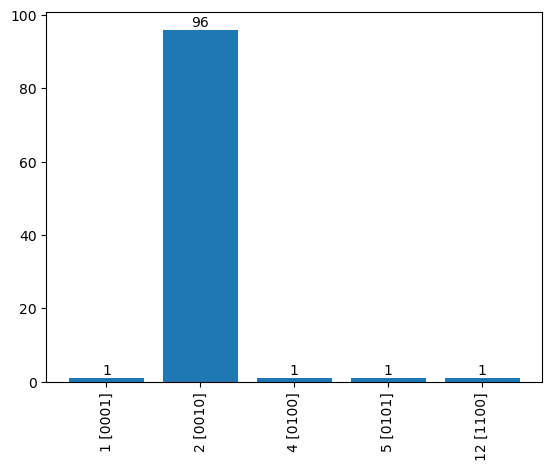

In [8]:
job = qckt.Job(fullckt, shots=100)
bk = Qeng()  # to run multiple shots, and see stats of readouts
# bk = Qdeb()  # to see Probe on state of interest
bk.runjob(job)
_ = job.plot_counts()